# How to access Sentinel-2 Level 3 Cloudless Quarterly Mosaics using the Process API

For more details on the individual steps in this notebook, compare with the "Introduction to Sentinel Hub API-s" notebook [here](https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/introduction_to_SH_APIs.ipynb):
First we import dependencies:

In [1]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

from utils import plot_image

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [24]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [25]:
# config = SHConfig("profile_name")

## Setting an area of interest

The bounding box in `WGS84` coordinate system is `[(longitude and latitude coordinates of lower left and upper right corners)]`. You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require a bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

In [3]:
aoi_coords_wgs84 = [12.292349, 47.810849, 12.569037, 47.967123]

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape. For a Process API request, the limit is 2500*2500 pixels, if the output below has larger values, you have to limit the bouding box or reduce the resolution.

In [4]:
resolution = 100
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 100 m resolution: (213, 167) pixels


## Process API request for Cloudless mosaics as a BYOC

### Example 1: True Color Image

We build the request according to the [API Reference](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). 

The information that we specify in the `SentinelHubRequest` object is:
- an evalscript,
- a list of input data collections with time interval,
- a format of the response,
- a bounding box and its size (size or resolution).
.

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L2A bands with some contrast enhancement.

- Here the data collection is defined as a [BYOC (Bring Your own COG)](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Byoc.html). The collection ID for this collection can be found [here](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html#access-sentinel-2-level-3-quarterly-mosaics-with-sentinel-hub): 

In [5]:
S2l3_cloudless_mosaic = DataCollection.define_byoc(
    collection_id="5460de54-082e-473a-b6ea-d5cbe3c17cca"
)

Then, we define the evalscript. The evalscript can be copied directly from the browser, eg. [this scene](https://link.dataspace.copernicus.eu/o2e) (click on the `</>` icon for the selected layer):  It is different from the generic true color evalscript for a single Sentinel-2 image, since it has to take care of contrast enhancement to provide a visually pleasing image for a large area.

In [6]:
evalscript_true_color = """
//VERSION=3
function setup() {
  return {
    input: ["B04","B03","B02", "dataMask"],
    output: { bands: 4 }
  };
}

// Contrast enhance / highlight compress

const maxR = 3.0; // max reflectance
const midR = 0.13;
const sat = 1.2;
const gamma = 1.8;
const scalefac = 10000;

function evaluatePixel(smp) {
  const rgbLin = satEnh(sAdj(smp.B04/scalefac), sAdj(smp.B03/scalefac), sAdj(smp.B02/scalefac));
  return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
}

function sAdj(a) {
  return adjGamma(adj(a, midR, 1, maxR));
}

const gOff = 0.01;
const gOffPow = Math.pow(gOff, gamma);
const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

function adjGamma(b) {
  return (Math.pow((b + gOff), gamma) - gOffPow)/gOffRange;
}

// Saturation enhancement
function satEnh(r, g, b) {
  const avgS = (r + g + b) / 3.0 * (1 - sat);
  return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
}

function clip(s) {
  return s < 0 ? 0 : s > 1 ? 1 : s;
}

//contrast enhancement with highlight compression
function adj(a, tx, ty, maxC) {
  var ar = clip(a / maxC, 0, 1);
  return ar * (ar * (tx/maxC + ty -1) - ty) / (ar * (2 * tx/maxC - 1) - tx/maxC);
}

const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);"""

Now we run the Process API Request. We set 
- the evalscript to the script we defined in the cell above,
- the input data
  - collection to the cloudless mosaic BYOC collection we defined in the previous cell,
  - the time of interest directly in the request parameter
-  responses of the script
-  the bounding box and AOI size as defined above
-  and finally the credentials as defined in the config (the second cell)
-  optionally, you can also give a location to save data by mentioning the path (`data_folder='./data'`)

In [7]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=S2l3_cloudless_mosaic,
            time_interval=("2023-04-01", "2023-04-02"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
    data_folder="./data",
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.If you want to save the data, make sure to set `save_data=True`

In [8]:
true_color_imgs = request_true_color.get_data(save_data=True)

In [9]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (167, 213, 4)


Now we call the plot function to print the image that we defined above.

Image type: uint8


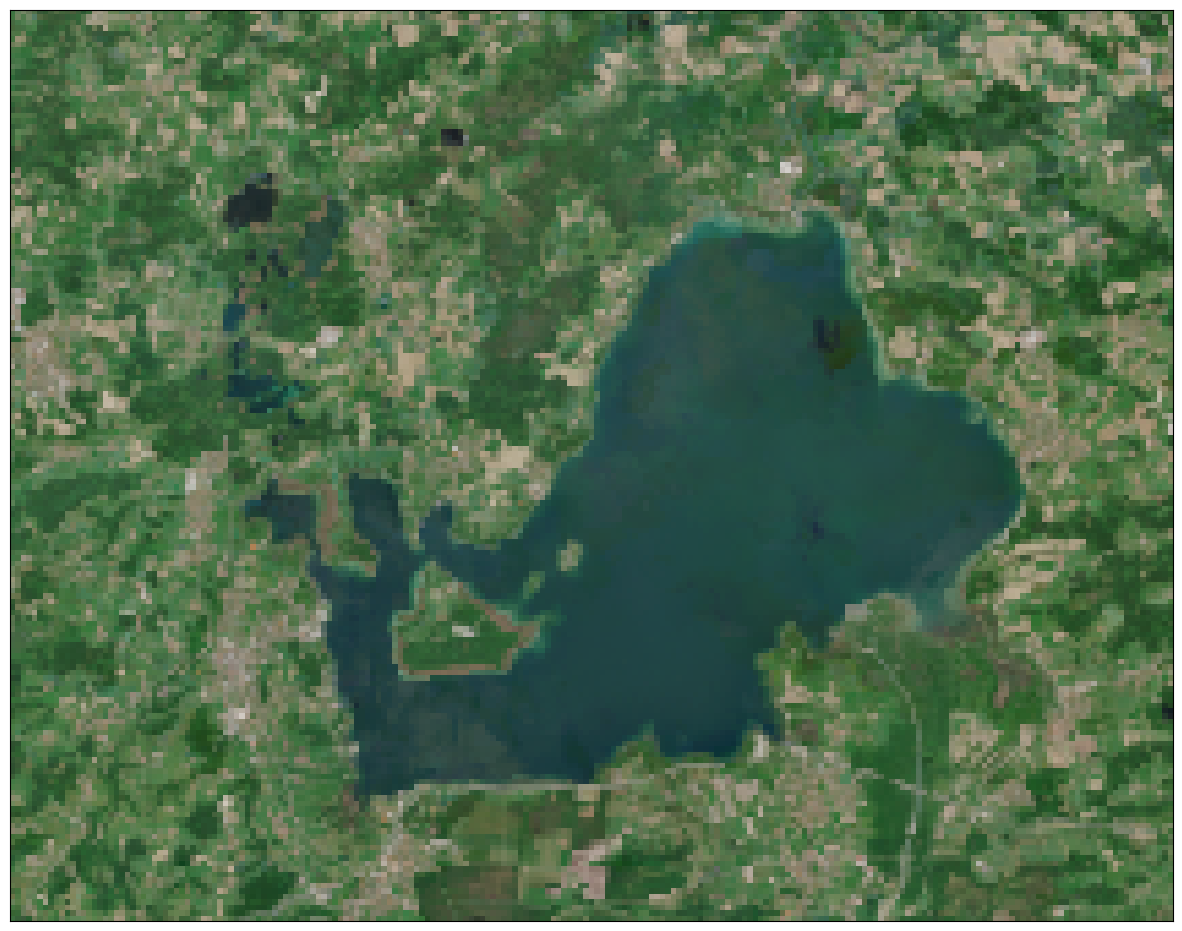

In [10]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 1 to keep brightness scaling that was already handled in the evalscript
plot_image(image, factor=1 / 255, clip_range=(0, 1))

## Summary

So what have we learnt in this notebook?

- How to modify a Process API request to access a BYOC dataset such as Sentinel-2 Level3 Cloud Free Mosaics.
- Visualising the derived image in a simple way
